https://www.kaggle.com/competitions/techx-facial-expression-recognition/

In [21]:
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

In [2]:
# PyTorch libraries and modules
import torch
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d 
from torch.nn import Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
from torchvision import datasets, transforms

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
# import Utils (models, ...)
sys.path.append("Utils/")
from RunModel_Pytorch import RunModel
from CustomModel_Pytorch import NeuralNet
from PlotModelOutput import PlotModel

In [6]:
# path dataset
path_train='dataset/train.csv'
path_val='dataset/val.csv'
path_test='dataset/test.csv'

In [7]:
# import dataset
train_df=pd.read_csv(path_train)
val_df=pd.read_csv(path_val, names=['emotion','pixels','Usage'])
test_df=pd.read_csv(path_test)

In [8]:
train_df.head(2)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


In [9]:
val_df.head(2)

,emotion,pixels,Usage
0,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
1,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest


In [10]:
test_df.head(2)

,id,pixel
0,1,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
1,2,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...


In [11]:
# get len pixels images
len_val=[]
for i in range (train_df.shape[0]):
    len_val.append(len(train_df['pixels'][i].split()))
    
set(len_val)

{2304}

In [12]:
np.sqrt(2304)

48.0

In [13]:
# Classes
classes=np.unique(train_df['emotion'])
classes

array([0, 1, 2, 3, 4, 5, 6])

In [14]:
# reshape pixels string to image format

train_df['image_pixels']=train_df['pixels'].apply(
    lambda x: np.array(x.split(), dtype=np.float32).reshape(48,48))

val_df['image_pixels']=val_df['pixels'].apply(
    lambda x: np.array(x.split(), dtype=np.float32).reshape(48,48))

test_df['image_pixels']=test_df['pixel'].apply(
    lambda x: np.array(x.split(), dtype=np.float32).reshape(48,48))

In [15]:
train_df.head(3)

,emotion,pixels,Usage,image_pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 11..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 16..."


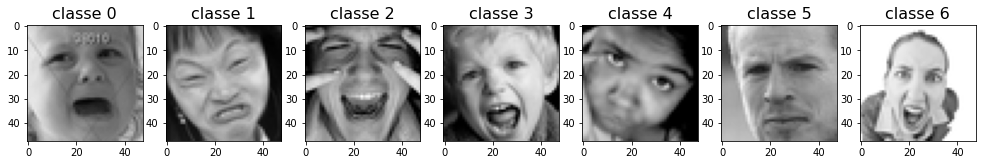

In [16]:
# plot train image examples
i=1
plt.figure(figsize = (17, 8))
for classe in classes:
    cl = train_df[train_df['emotion'] == 0]['image_pixels'].sample(n=2).values[0]
    ax=plt.subplot(1,7,i)
    plt.imshow(cl, cmap='gray', vmin=0, vmax=255)
    plt.title('classe {}'.format(classe),fontsize=16)
    i+=1

# CNN PyTorch

In [17]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
#valid_size = 0.2

### Transforms Compose

In [18]:
# convert data to normalized torch.FloatTensor
train_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
    ])

test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
    ])

In [19]:
# Custon Dataset
class ImageDataset():
    def __init__(self,dataset, transform=False):
        self.dataset=dataset
        self.transform=transform

    # returns the number of samples.
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self,index):
        
        features = self.dataset['image_pixels'][index]        
        images = Image.fromarray(features)        
        if self.transform is not None:
            images = self.transform(images)
         
        name =[x for x in globals() if globals()[x] is self.dataset][0]
        
        if 'test' in name: 
            return images
        else:
            targets = self.dataset['emotion'][index]
            return images, targets

In [20]:
len(train_df)

28709

In [21]:
# Load dataset and apply transformations
train_dataset=ImageDataset(train_df, train_transform)
val_dataset=ImageDataset(val_df, test_transform)
test_dataset=ImageDataset(test_df, test_transform)

In [22]:
len(train_dataset)

28709

In [23]:
# data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True)

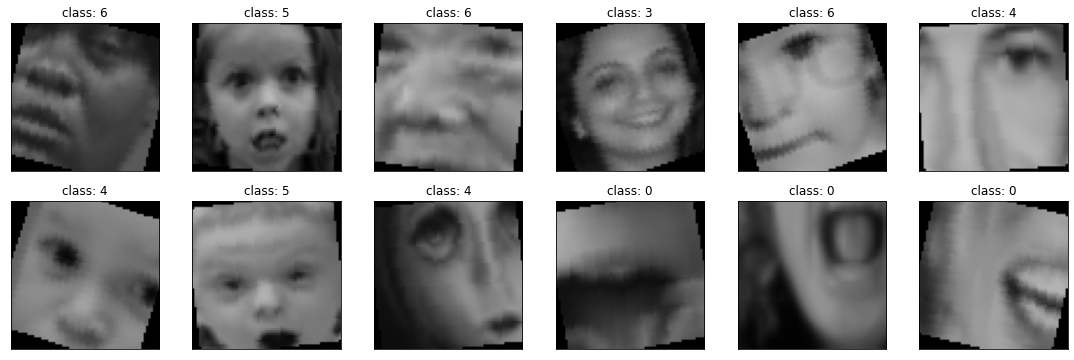

In [24]:
# visualize a batch of the train data loader
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(19, 6))
for i in np.arange(12):
    ax = fig.add_subplot(2, 6, i+1, xticks=[], yticks=[])
    image_ = np.transpose(images[i], (1, 2, 0)) 
    image_ = image_*[0.18]+[0.4] # unnormalize 
    plt.imshow(image_, cmap='gray', vmin=0, vmax=255)
    plt.title('class: {}'.format(labels[i]))

In [8]:
# plot output function
def plot_model_output(history, name='model'):
    
    loss_values = history['train_loss']
    val_loss_values = history['val_loss']
    accuracy_values = history['train_acc']
    val_accuracy_values = history['val_acc']
    
    fig = plt.figure(figsize=(19,3))
    
    plt.subplot(1, 2, 1)
    plt.suptitle(name, fontsize=18)
    plt.title('loss')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,loss_values, '--',label='loss')
    plt.plot(epoch,val_loss_values, '--',label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.suptitle(name, fontsize=18)
    plt.title('accuracy')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,accuracy_values, '--',label='accuracy')
    plt.plot(epoch,val_accuracy_values, '--',label='val_accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

### Pretrained Models

In [25]:
model_resnet18 = models.resnet18(pretrained=True)
for name, param in model_resnet18.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [26]:
model_resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [27]:
# gray image
model_resnet18.conv1=Sequential(Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False))
model_resnet18.conv1

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)

In [28]:
# output
model_resnet18.fc = Sequential(Linear(model_resnet18.fc.in_features,1000),
                                  ReLU(),
                                  Dropout(0.5),
                                  Linear(1000, len(classes)))

In [29]:
def valid_model(model):
    sum_correct = 0
    sum_total = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1], labels).view(-1)
            sum_correct += torch.sum(correct).item()
            sum_total += correct.shape[0]  
    print('correct: {:d}  total: {:d}'.format(sum_correct, sum_total))
    print('accuracy = {:f}'.format(sum_correct / sum_total))
    return F.softmax(outputs, dim=1)

In [30]:
# checking that the model works
#valid_model(model_resnet18)

In [31]:
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=4, threshold=0.000001, threshold_mode='abs', verbose=True)
model_save='Models/modelo_resnet18.pth'
# RunModel
history = RunModel(model_resnet18, train_loader, valid_loader, criterion, optimizer,
                   scheduler, model_save, n_epochs=30).train_model()

cpu


Epoch: 1, Training_Loss: 1.8254, Validation_Loss: 1.7716, Training_accuracy = 0.2386, Validation_accuracy = 0.2675, lr = 0.001
Validation loss decreased (inf --> 1.771582).  Saving model ...


Epoch: 2, Training_Loss: 1.7805, Validation_Loss: 1.7006, Training_accuracy = 0.2649, Validation_accuracy = 0.3045, lr = 0.001
Validation loss decreased (1.771582 --> 1.700624).  Saving model ...


Epoch: 3, Training_Loss: 1.7547, Validation_Loss: 1.6592, Training_accuracy = 0.2833, Validation_accuracy = 0.3360, lr = 0.001
Validation loss decreased (1.700624 --> 1.659209).  Saving model ...


Epoch: 4, Training_Loss: 1.7280, Validation_Loss: 1.6111, Training_accuracy = 0.2956, Validation_accuracy = 0.3553, lr = 0.001
Validation loss decreased (1.659209 --> 1.611054).  Saving model ...


Epoch: 5, Training_Loss: 1.7082, Validation_Loss: 1.5734, Training_accuracy = 0.3083, Validation_accuracy = 0.3697, lr = 0.001
Validation loss decreased (1.611054 --> 1.573434).  Saving model ...


Epoch: 6, Training_Loss: 1.6968, Validation_Loss: 1.5326, Training_accuracy = 0.3157, Validation_accuracy = 0.4048, lr = 0.001
Validation loss decreased (1.573434 --> 1.532613).  Saving model ...


Epoch: 7, Training_Loss: 1.6798, Validation_Loss: 1.5751, Training_accuracy = 0.3281, Validation_accuracy = 0.3898, lr = 0.001


Epoch: 8, Training_Loss: 1.6652, Validation_Loss: 1.5095, Training_accuracy = 0.3327, Validation_accuracy = 0.4099, lr = 0.001
Validation loss decreased (1.532613 --> 1.509501).  Saving model ...


Epoch: 9, Training_Loss: 1.6596, Validation_Loss: 1.5063, Training_accuracy = 0.3374, Validation_accuracy = 0.4160, lr = 0.001
Validation loss decreased (1.509501 --> 1.506290).  Saving model ...


Epoch: 10, Training_Loss: 1.6485, Validation_Loss: 1.4750, Training_accuracy = 0.3410, Validation_accuracy = 0.4238, lr = 0.001
Validation loss decreased (1.506290 --> 1.474956).  Saving model ...


Epoch: 11, Training_Loss: 1.6375, Validation_Loss: 1.4766, Training_accuracy = 0.3467, Validation_accuracy = 0.4241, lr = 0.001


Epoch: 12, Training_Loss: 1.6319, Validation_Loss: 1.5205, Training_accuracy = 0.3502, Validation_accuracy = 0.3934, lr = 0.001


Epoch: 13, Training_Loss: 1.6267, Validation_Loss: 1.4745, Training_accuracy = 0.3520, Validation_accuracy = 0.4135, lr = 0.001
Validation loss decreased (1.474956 --> 1.474471).  Saving model ...


Epoch: 14, Training_Loss: 1.6217, Validation_Loss: 1.4608, Training_accuracy = 0.3576, Validation_accuracy = 0.4232, lr = 0.001
Validation loss decreased (1.474471 --> 1.460848).  Saving model ...


Epoch: 15, Training_Loss: 1.6125, Validation_Loss: 1.4530, Training_accuracy = 0.3594, Validation_accuracy = 0.4305, lr = 0.001
Validation loss decreased (1.460848 --> 1.452998).  Saving model ...


Epoch: 16, Training_Loss: 1.6147, Validation_Loss: 1.4390, Training_accuracy = 0.3607, Validation_accuracy = 0.4305, lr = 0.001
Validation loss decreased (1.452998 --> 1.438996).  Saving model ...


Epoch: 17, Training_Loss: 1.6034, Validation_Loss: 1.4562, Training_accuracy = 0.3649, Validation_accuracy = 0.4269, lr = 0.001


Epoch: 18, Training_Loss: 1.5934, Validation_Loss: 1.4095, Training_accuracy = 0.3684, Validation_accuracy = 0.4505, lr = 0.001
Validation loss decreased (1.438996 --> 1.409477).  Saving model ...


Epoch: 19, Training_Loss: 1.5928, Validation_Loss: 1.4275, Training_accuracy = 0.3681, Validation_accuracy = 0.4450, lr = 0.001


Epoch: 20, Training_Loss: 1.5804, Validation_Loss: 1.3962, Training_accuracy = 0.3714, Validation_accuracy = 0.4634, lr = 0.001
Validation loss decreased (1.409477 --> 1.396230).  Saving model ...


Epoch: 21, Training_Loss: 1.5803, Validation_Loss: 1.3995, Training_accuracy = 0.3705, Validation_accuracy = 0.4553, lr = 0.001


Epoch: 22, Training_Loss: 1.5755, Validation_Loss: 1.4092, Training_accuracy = 0.3748, Validation_accuracy = 0.4489, lr = 0.001


Epoch: 23, Training_Loss: 1.5780, Validation_Loss: 1.4176, Training_accuracy = 0.3793, Validation_accuracy = 0.4528, lr = 0.001


Epoch: 24, Training_Loss: 1.5649, Validation_Loss: 1.3879, Training_accuracy = 0.3806, Validation_accuracy = 0.4614, lr = 0.001
Validation loss decreased (1.396230 --> 1.387868).  Saving model ...


Epoch: 25, Training_Loss: 1.5598, Validation_Loss: 1.3984, Training_accuracy = 0.3831, Validation_accuracy = 0.4636, lr = 0.001


Epoch: 26, Training_Loss: 1.5658, Validation_Loss: 1.3880, Training_accuracy = 0.3832, Validation_accuracy = 0.4656, lr = 0.001


Epoch: 27, Training_Loss: 1.5603, Validation_Loss: 1.3824, Training_accuracy = 0.3843, Validation_accuracy = 0.4709, lr = 0.001
Validation loss decreased (1.387868 --> 1.382360).  Saving model ...


Epoch: 28, Training_Loss: 1.5584, Validation_Loss: 1.4113, Training_accuracy = 0.3898, Validation_accuracy = 0.4452, lr = 0.001


Epoch: 29, Training_Loss: 1.5585, Validation_Loss: 1.3776, Training_accuracy = 0.3901, Validation_accuracy = 0.4684, lr = 0.001
Validation loss decreased (1.382360 --> 1.377567).  Saving model ...


Epoch: 30, Training_Loss: 1.5532, Validation_Loss: 1.3724, Training_accuracy = 0.3919, Validation_accuracy = 0.4712, lr = 0.001
Validation loss decreased (1.377567 --> 1.372422).  Saving model ...


In [33]:
# post-trained
valid_model(model_resnet18)

correct: 1691  total: 3589
accuracy = 0.471162


tensor([[0.1440, 0.0183, 0.2108, 0.2182, 0.1602, 0.1268, 0.1216],
        [0.1012, 0.0089, 0.2624, 0.0677, 0.1098, 0.3094, 0.1406],
        [0.1104, 0.0025, 0.2034, 0.3654, 0.0204, 0.2832, 0.0148],
        [0.1047, 0.0047, 0.1705, 0.0147, 0.2753, 0.0326, 0.3975],
        [0.1038, 0.0115, 0.1577, 0.2221, 0.1652, 0.1149, 0.2248],
        [0.1368, 0.0103, 0.1409, 0.0912, 0.2609, 0.0323, 0.3276],
        [0.1329, 0.0093, 0.0849, 0.5008, 0.1278, 0.0388, 0.1055],
        [0.0798, 0.0032, 0.1635, 0.0422, 0.3361, 0.0322, 0.3430],
        [0.0156, 0.0018, 0.0106, 0.8948, 0.0109, 0.0112, 0.0550]])

In [10]:
history_file = open("history_resnet18.pkl", "wb")
pickle.dump(history, history_file)
history_file.close()

In [6]:
history_file = open("history_resnet18.pkl", "rb")
history = pickle.load(history_file)
history_file.close()
#print(history)

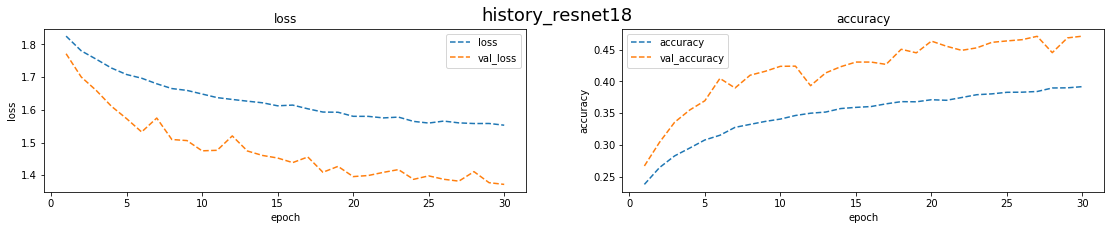

In [9]:
plot_model_output(history, name='history_resnet18')

### big_transfer_pytorch

In [ ]:
import requests
import io

In [ ]:
def get_weights(bit_variant):
    response = requests.get(f'https://storage.googleapis.com/bit_models/{bit_variant}.npz')
    response.raise_for_status()
    return np.load(io.BytesIO(response.content))

In [ ]:
weights = get_weights('BiT-M-R50x1')  # You could use other variants, such as R101x3 or R152x4

In [ ]:
weights

### > make predictions

In [17]:
test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
    ])

In [18]:
# Load saved model
model_resnet18 = torch.load('Models/modelo_resnet18.pth')
#model_resnet18.eval()

In [23]:
# make prdictions
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def make_prediction(model, filename):
    #labels, _ = find_classes(path)
    img = Image.open(filename)
    img = ImageOps.grayscale(img)
    img = test_transform(img)   
    img = img.unsqueeze(0)
    prediction = model(img.to(device))
    prediction = prediction.argmax()
    print('class predicted: ',prediction.item())
    
make_prediction(model_resnet18, '/home/hellraiser/JRE.jpg')

class predicted:  4
